# Data From
https://github.com/Anand-GitH/TweetSentiAnalysis/tree/master/TweetSentiAnalysis

In [2]:
# Package Imports

import sklearn as sk
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from sqlalchemy import create_engine


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
# Set the random seed so things are reproducible
random_state = 42

In [3]:
#import the sql database with the polars function
conn = create_engine("sqlite:////home/troy/ml/project1/SentimentAnalysis.db")

#SQL query to get the date, close price, and sentiment score from the Database
SQLquery = """
SELECT 
    TS.Date AS StockDate,
    TS.Close AS StockClosingPrice,
    T.Score AS TweetScore
FROM 
    Tesla_Stock TS
JOIN 
    Tweet_data TD
ON 
    DATE(TS.Date) = DATE(TD.Creation_dt)
JOIN 
    Tweet_Scores T
ON 
    TD.ID = T.ID;

"""
new_query = """
SELECT 
    TS.Date AS StockDate,
    TS.Close AS StockClosingPrice,
    AVG(T.Score) AS TweetScore  -- Aggregate multiple tweets per day
FROM 
    Tesla_Stock TS
JOIN 
    Tweet_data TD
ON 
    DATE(TS.Date) = DATE(TD.Creation_dt)
JOIN 
    Tweet_Scores T
ON 
    TD.ID = T.ID
GROUP BY TS.Date;  -- Ensure only one row per date

"""

df = pl.read_database(query=new_query, connection=conn)
df

#We are concerned about stockDate, StockClosingPrice, and TweetScore
#We will use the stockClosingPrice as the target variable and the TweetScore as the feature variable
#We will use the date as the index
X = np.array(df['TweetScore']).reshape(-1,1)
y = np.array(df['StockClosingPrice'])
date = np.array(df['StockDate'])


#Out of curiosity, How will the model perform if we just split the model down 50/50

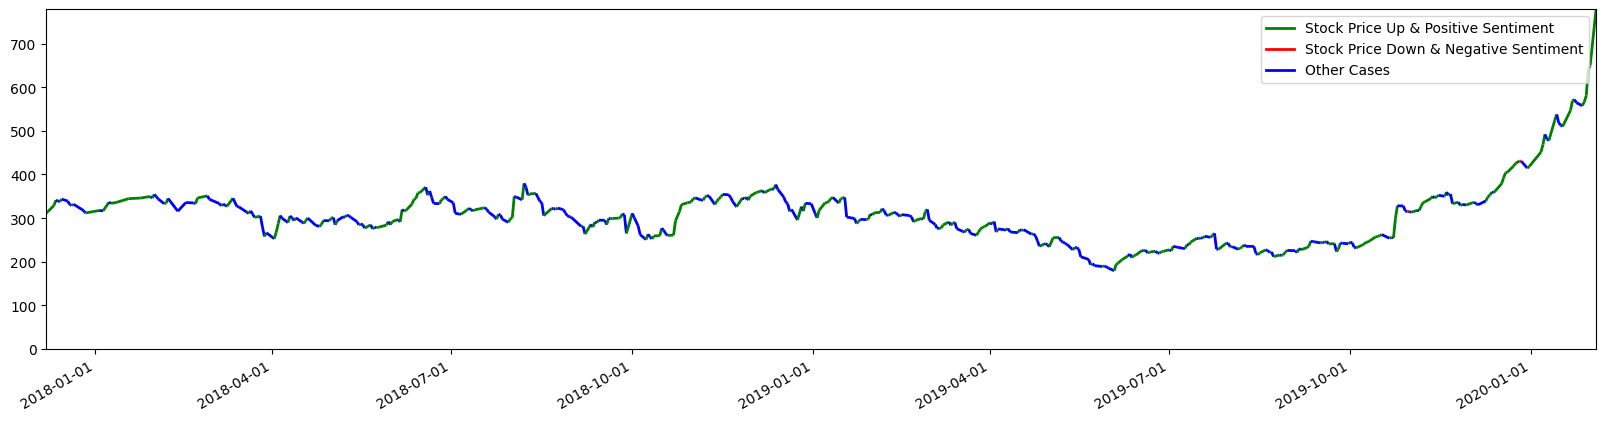

In [4]:
# Convert dates to matplotlib numeric format
dates = mdates.date2num(df['StockDate'])
prices = df['StockClosingPrice'].to_numpy()
scores = df['TweetScore'].to_numpy()

# Create segments for the stock price line
points = np.array([dates, prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Calculate price differences and get corresponding scores
price_diff = np.diff(prices)
score_segment = scores[1:]

# Determine colors for each segment
colors = []
for pd, sc in zip(price_diff, score_segment):
    if pd > 0 and sc > 0:
        colors.append('green')
    elif pd < 0 and sc < 0:
        colors.append('red')
    else:
        colors.append('blue')

# Create LineCollection for stock price with segmented colors
lc = LineCollection(segments, colors=colors, linewidth=2)

# Plotting
plt.figure(figsize=(20, 5))
ax = plt.gca()
ax.add_collection(lc)


# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()

# Set axis limits
ax.set_xlim(dates.min(), dates.max())
ax.set_ylim(min(prices.min(), scores.min()), max(prices.max(), scores.max()))

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='Stock Price Up & Positive Sentiment'),
    Line2D([0], [0], color='red', lw=2, label='Stock Price Down & Negative Sentiment'),
    Line2D([0], [0], color='blue', lw=2, label='Other Cases'),
]
plt.legend(handles=legend_elements)

plt.show()

## Q2.2

In [5]:
#Set aside 10% of the data for testing. This test will be used to compare the final perfrormace of all the models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)


In [6]:
## Q 2.3 Use the mean squared error for your error function
# IN scikit-learn use neg_mean_squared_error
## Q2.4 Use k-fold cross validation with k=5

In [7]:
#Chose and train a baseline model as a sanity check.
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dummy_scores = -cross_val_score(dummy, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
print("Sanity check baseline model:",  dummy_scores.mean())

Sanity check baseline model: 4850.589777429059


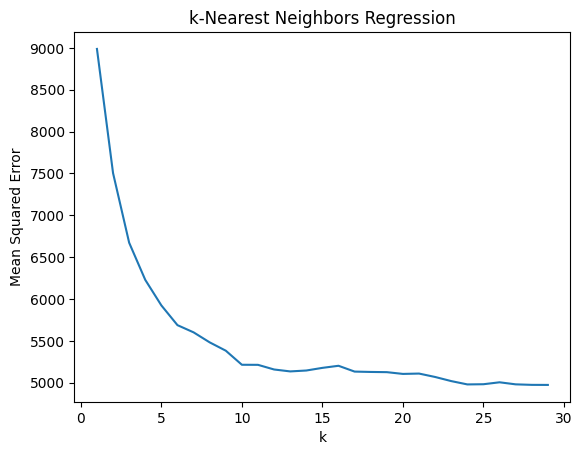

Best k value: 29
Best k value score: 4972.893549301672
k-Nearest Neighbors Regression MSE: 5964.272248263971


In [15]:
#Use k-Nearest-Neighbors regression to predict the stock price
#Perform a hyperparameter sweep to find the best k value
k_sweep = range(1, 30)
k_scores = []
for k in k_sweep:
    pipe = make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors=k) )
    knn_scores = -cross_val_score(pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    k_scores.append(knn_scores.mean())

#Create a plot with hyperparameters vs the estimated results of Enew
plt.plot(k_sweep, k_scores)
plt.xlabel('k')
plt.ylabel('Mean Squared Error')
plt.title('k-Nearest Neighbors Regression')
plt.show()

#Find to hyperparameter that gives the best result
best_k = k_sweep[np.argmin(k_scores)]
print("Best k value:", best_k)
print("Best k value score:", min(k_scores))

#Train the final model with the best hyperparameter
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

knn_mse = mean_squared_error(y_test, knn_pred)
print("k-Nearest Neighbors Regression MSE:", knn_mse)

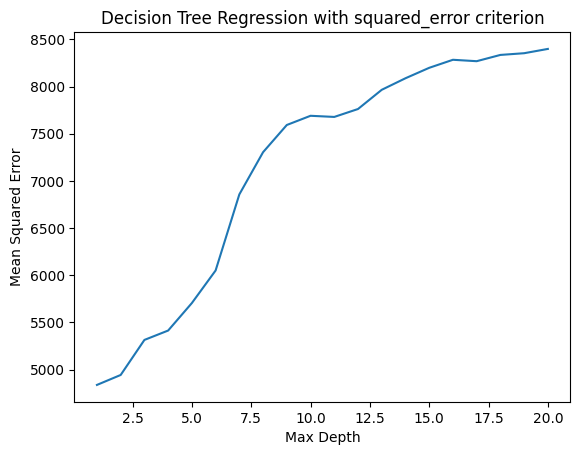

Best max depth: 1
Best max depth score: 4838.15331524741


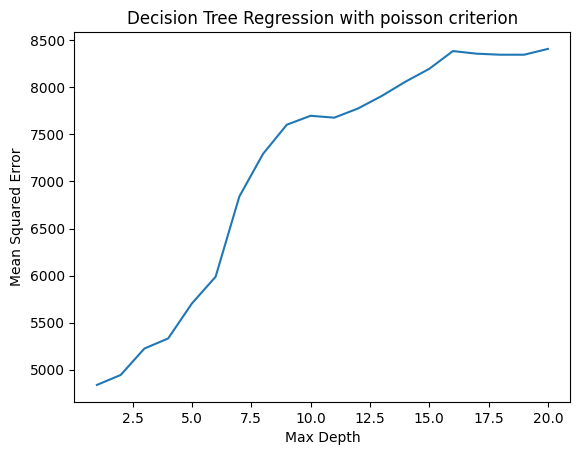

Best max depth: 1
Best max depth score: 4838.15331524741


In [16]:
#Use Decision Tree regression to predict the stock price
#Perform a hyperparameter sweep to find the best max depth
criterion = ['squared_error', 'poisson']
for c in criterion:
    depth_sweep = range(1, 21)
    depth_scores = []
    for depth in depth_sweep:
        dt = DecisionTreeRegressor(max_depth=depth, random_state = random_state, criterion=c)
        dt.fit(X_train, y_train)
        dt_scores = -cross_val_score(dt, X_train, y_train, scoring='neg_mean_squared_error', cv = 10)
        depth_scores.append(dt_scores.mean())

    #Create a plot with hyperparameters vs the estimated results of Enew
    plt.plot(depth_sweep, depth_scores)
    plt.xlabel('Max Depth')
    plt.ylabel('Mean Squared Error')
    plt.title('Decision Tree Regression with ' + c + ' criterion')
    plt.show()

    #Find to hyperparameter that gives the best result
    best_depth = depth_sweep[np.argmin(depth_scores)]
    print("Best max depth:", best_depth)
    print("Best max depth score:", min(depth_scores))

In [17]:
# Train the final model on the full training set using the best max_depth
final_dt = DecisionTreeRegressor(max_depth=best_depth, criterion="squared_error", random_state=random_state)
final_dt.fit(X_train, y_train)
# Evaluate the final model on the holdout test set
y_pred = final_dt.predict(X_test)
test_mse = np.mean((y_pred - y_test) ** 2)
print("Test MSE on holdout test set:", test_mse)

Test MSE on holdout test set: 6050.978003738717


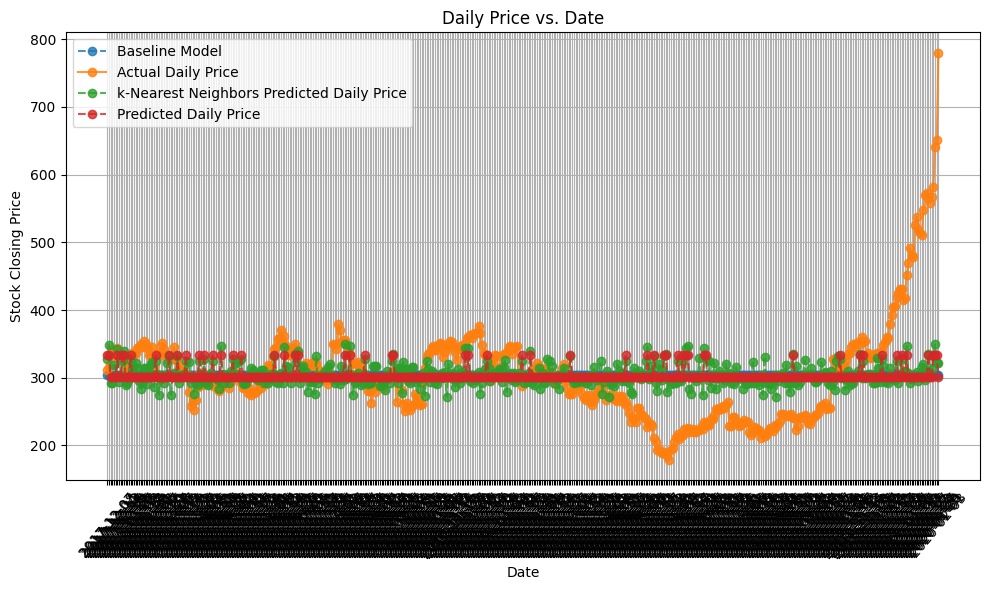

In [11]:
y_pred = final_dt.predict(X)
knn_pred = knn.predict(X)
baseline = dummy.predict(X)

plt.figure(figsize=(10, 6))
plt.plot(date, baseline, 'o--', label="Baseline Model", alpha=0.8)
plt.plot(date, y, 'o-', label="Actual Daily Price", alpha=0.8)
plt.plot(date, knn_pred, 'o--', label="k-Nearest Neighbors Predicted Daily Price", alpha=0.8)
plt.plot(date, y_pred, 'o--', label="Predicted Daily Price", alpha=0.8)


plt.title("Daily Price vs. Date")
plt.xlabel("Date")
plt.ylabel("Stock Closing Price")
plt.xticks(rotation=50)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()